<a href="https://colab.research.google.com/github/kitamura-felipe/deeplearning_head_ct_demo/blob/master/MC9_ConnectToPACS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Magicians Corner 9 - How to connect an algorithm to a PACS

###by: Bradley J Erickson, MD PhD and Felipe Kitamura, MD MSc
*Copyright 2020

###See corresponding Radiology: AI article here:

In this tutorial we will:



1.   Connect to a PACS
2.   Test if the connection is estabilished
3.   Query the PACS for a specific study
4.   Retrieve this study
5.   Perform an inference on this study.
6.   Return the result

We will use an open PACS used for testing (https://www.dicomserver.co.uk/).


Acknowledgements to pydicom and pynetdicom developers in keeping a complete documentation.


In [30]:
# Cell 1
# First we will install he libraries we will use.

!pip install pynetdicom #this is the DICOM DIMSE protocol library for Python

In [0]:
# Cell 2
# Then we import some useful libraries, including the last one we installed

from pynetdicom import (
    AE, evt, build_role,
    StoragePresentationContexts,
    PYNETDICOM_IMPLEMENTATION_UID,
    PYNETDICOM_IMPLEMENTATION_VERSION
)
from pynetdicom.sop_class import (
    StudyRootQueryRetrieveInformationModelFind,
    PatientRootQueryRetrieveInformationModelGet,
    StudyRootQueryRetrieveInformationModelGet,
    StudyRootQueryRetrieveInformationModelMove,
    CTImageStorage

)

import pydicom
from pydicom import dcmread
from pydicom.dataset import Dataset
import os
from matplotlib import pyplot as plt
from glob import glob

In [0]:
# Cell3
# We must set up the information about PACS we will connect to

PACS_addr = "www.dicomserver.co.uk"
port = 104

In [3]:
# Cell 4
# Now we connect to the PACS and send a C-ECHO to test if we were able to establish connection

ae = AE(ae_title=b'ANY-SCU')
# Verification SOP Class has a UID of 1.2.840.10008.1.1
#   we can use the UID str directly when adding the requested
#   presentation context
ae.add_requested_context('1.2.840.10008.1.1')
ae.add_requested_context(StudyRootQueryRetrieveInformationModelFind)

# Associate with a peer AE
assoc = ae.associate(PACS_addr, port)

if assoc.is_established:
    print("Association established.")
    # Send a DIMSE C-ECHO request to the peer
    status = assoc.send_c_echo()

    # Print the response from the peer
    if status:
        print('C-ECHO Response: 0x{0:04x}'.format(status.Status))

    # Release the association
    assoc.release()
    print("Association Released.")
else:
    print("Association not established.")

Association established.
C-ECHO Response: 0x0000
Association Released.


A C-ECHO Response of 0x0000 means we were able to communicate with the PACS

In [4]:
# Cell 5
# Then we define the filters to query the specific study of interest

ds = pydicom.Dataset()
ds.PatientName = '*'
ds.Modality = 'CT'
ds.StudyDescription = '*'
ds.QueryRetrieveLevel = 'STUDY'
ds.AccessionNumber = '1976733239'
ds.PatientID = '*'
ds.StudyInstanceUID = '*'
# print the group and elements just to see what is there
ds

(0008, 0050) Accession Number                    SH: '1976733239'
(0008, 0052) Query/Retrieve Level                CS: 'STUDY'
(0008, 0060) Modality                            CS: 'CT'
(0008, 1030) Study Description                   LO: '*'
(0010, 0010) Patient's Name                      PN: '*'
(0010, 0020) Patient ID                          LO: '*'
(0020, 000d) Study Instance UID                  UI: *

We will filter by AccessionNumber, a DICOM tag that should be unique for each study.
The other tags with value '*' tell the PACS we want those information back.

In [5]:
# Cell 6

# Here we establish a connection again, but now we will send a C-FIND to query the PACS using the filter we defined before.

ae = AE(ae_title=b'ANY-SCU')
# Verification SOP Class has a UID of 1.2.840.10008.1.1
#   we can use the UID str directly when adding the requested
#   presentation context
ae.add_requested_context('1.2.840.10008.1.1')
ae.add_requested_context(StudyRootQueryRetrieveInformationModelFind)

# Associate with a peer AE
assoc = ae.associate(PACS_addr, port)

if assoc.is_established:
    # Send a DIMSE C-ECHO request to the peer
    status = assoc.send_c_echo()

    # Print the response from the peer
    if status:
        print('C-ECHO Response: 0x{0:04x}'.format(status.Status))
        responses = assoc.send_c_find(ds,StudyRootQueryRetrieveInformationModelFind)
        for (status, identifier) in responses:
            if status:
                print('C-FIND query status: 0x{0:04x}'.format(status.Status))

                # If the status is 'Pending' then identifier is the C-FIND response
                if status.Status in (0xFF00, 0xFF01):
                    print(identifier)
                    StudyFound = identifier
            else:
                print('Connection timed out, was aborted or received invalid response')
    # Release the association
    assoc.release()
    print("Association Released.")

C-ECHO Response: 0x0000
C-FIND query status: 0xff00
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0050) Accession Number                    SH: '1976733239'
(0008, 0052) Query/Retrieve Level                CS: 'STUDY'
(0008, 0054) Retrieve AE Title                   AE: 'ANY-SCP'
(0008, 1030) Study Description                   LO: 'ABD_CT'
(0010, 0010) Patient's Name                      PN: 'SITE1-000001'
(0010, 0020) Patient ID                          LO: 'SITE1-000001'
(0020, 000d) Study Instance UID                  UI: 1.2.826.0.1.3680043.10.474.1701500621956658007306336775407256964
C-FIND query status: 0x0000
Association Released.


The output above shows the information of the study we found in the PACS. We will use the StudyInstanceUID as the identifier to download this study from the PACS to this Colab Notebook.

In [36]:
# Cell 7
# Having found a study of interest, we will send a C-GET to download it

path = 'study/' # Folder to save the incoming DICOM files
os.makedirs(path, exist_ok=True)

# Implement the handler for evt.EVT_C_STORE
def handle_store(event):
    """Handle a C-STORE request event."""
    ds = event.dataset
    context = event.context

    # Add the DICOM File Meta Information
    meta = pydicom.Dataset()
    meta.MediaStorageSOPClassUID = ds.SOPClassUID
    meta.MediaStorageSOPInstanceUID = ds.SOPInstanceUID
    meta.ImplementationClassUID = PYNETDICOM_IMPLEMENTATION_UID
    meta.ImplementationVersionName = PYNETDICOM_IMPLEMENTATION_VERSION
    meta.TransferSyntaxUID = context.transfer_syntax

    # Add the file meta to the dataset
    ds.file_meta = meta

    # Set the transfer syntax attributes of the dataset
    ds.is_little_endian = context.transfer_syntax.is_little_endian
    ds.is_implicit_VR = context.transfer_syntax.is_implicit_VR

    print("Saving file: " + ds.SOPInstanceUID + ".dcm")
    # Save the dataset using the SOP Instance UID as the filename    
    ds.save_as(path + ds.SOPInstanceUID + ".dcm", write_like_original=False)

    # Return a 'Success' status
    return 0x0000

handlers = [(evt.EVT_C_STORE, handle_store)]

# Initialise the Application Entity
ae = AE()

# Add the requested presentation contexts (QR SCU)
ae.add_requested_context(StudyRootQueryRetrieveInformationModelGet)
# Add the requested presentation context (Storage SCP)
ae.add_requested_context(CTImageStorage)

# Create an SCP/SCU Role Selection Negotiation item for CT Image Storage
role = build_role(CTImageStorage, scp_role=True)

# Create our Identifier (query) dataset
# We need to supply a Unique Key Attribute for each level above the
#   Query/Retrieve level
ds = pydicom.Dataset()
ds.QueryRetrieveLevel = 'STUDY'
ds.StudyInstanceUID = StudyFound.StudyInstanceUID # Use the StudyInstanceUID from the study we found before


# Associate with peer AE at PACS_addr and port defined in the beginning 
assoc = ae.associate(PACS_addr, port, ext_neg=[role], evt_handlers=handlers)

if assoc.is_established:
    # Use the C-GET service to send the identifier
    responses = assoc.send_c_get(ds, StudyRootQueryRetrieveInformationModelGet)

    for (status, identifier) in responses:
        if status:
            print('C-GET query status: 0x{0:04x}'.format(status.Status))
        else:
            print('Connection timed out, was aborted or received invalid response')

    # Release the association
    assoc.release()
else:
    print('Association rejected, aborted or never connected')

Saving file: 1.2.826.0.1.3680043.10.474.2332146034493138958298615375617313497.dcm
C-GET query status: 0xff00
Saving file: 1.2.826.0.1.3680043.10.474.2748221385247866211657215336285918110.dcm
C-GET query status: 0xff00
Saving file: 1.2.826.0.1.3680043.10.474.7007230814961666922572356249864755351.dcm
C-GET query status: 0xff00
Saving file: 1.2.826.0.1.3680043.10.474.2370704327333239386538351527309903271.dcm
C-GET query status: 0xff00
Saving file: 1.2.826.0.1.3680043.10.474.3458679939601229935248121465470931959.dcm
C-GET query status: 0xff00
Saving file: 1.2.826.0.1.3680043.10.474.2507771891090035370921911196718328182.dcm
C-GET query status: 0xff00
Saving file: 1.2.826.0.1.3680043.10.474.3188304474330707914759740870960569486.dcm
C-GET query status: 0xff00
Saving file: 1.2.826.0.1.3680043.10.474.1587183705870117055211896368980215442.dcm
C-GET query status: 0xff00
Saving file: 1.2.826.0.1.3680043.10.474.3257627417528558548743783497737619116.dcm
C-GET query status: 0xff00
Saving file: 1.2.82

A C-GET query status of 0xff00 means there are pending operations (files to be transfered). A C-GET status of 0x0000 means operation finished.

In [37]:
# Cell 8

# We can list the files in the study/ folder to see if the DICOM files were downloaded properly.

#!rm -rf study/
!ls study/


1.2.826.0.1.3680043.10.474.1012160534305787074124387823229229037.dcm
1.2.826.0.1.3680043.10.474.1041141576814680323233453456912923514.dcm
1.2.826.0.1.3680043.10.474.1045360463185744008220045944517179737.dcm
1.2.826.0.1.3680043.10.474.1110009020315640966864157479430311112.dcm
1.2.826.0.1.3680043.10.474.1119412616879119569022224303786504321.dcm
1.2.826.0.1.3680043.10.474.1131914659380236603876937558576788468.dcm
1.2.826.0.1.3680043.10.474.1158718188350356128363655827396642111.dcm
1.2.826.0.1.3680043.10.474.1170477655174526785091723213356387445.dcm
1.2.826.0.1.3680043.10.474.1192706089371564689493868094029554891.dcm
1.2.826.0.1.3680043.10.474.1297887167559858236308699375200769776.dcm
1.2.826.0.1.3680043.10.474.1303726620898672737282451045848370176.dcm
1.2.826.0.1.3680043.10.474.1343397768080917270589317243292796620.dcm
1.2.826.0.1.3680043.10.474.1496927650582883459860450558003588074.dcm
1.2.826.0.1.3680043.10.474.1537144084455033101892710184039124419.dcm
1.2.826.0.1.3680043.10.474.1538128

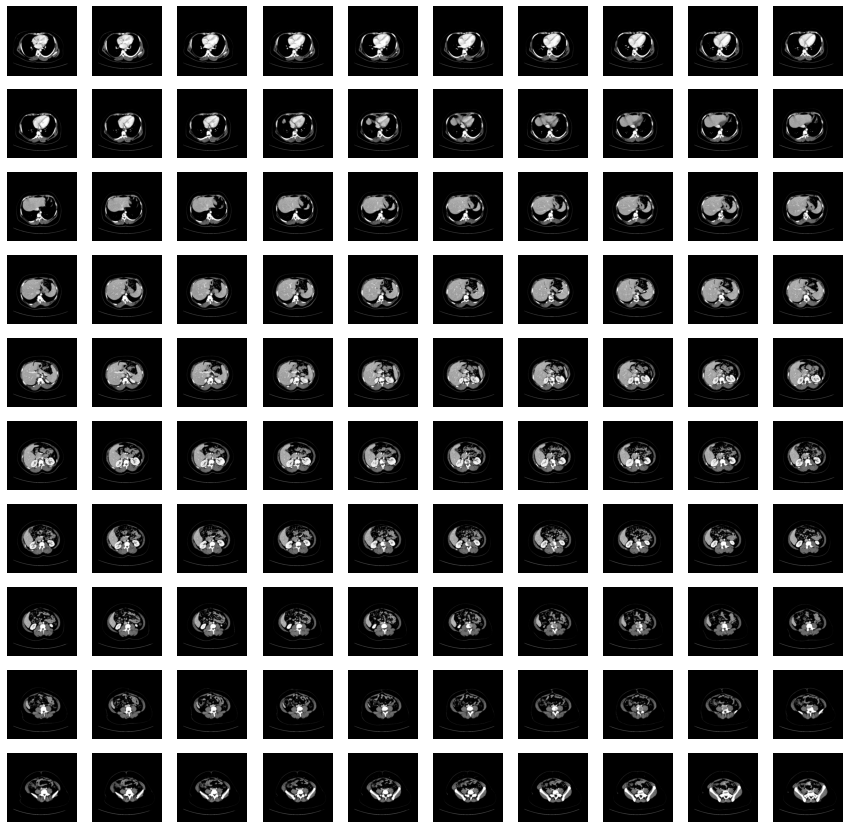

In [38]:
# Cell 9

# Let's take a look at the files we've just retrieved from the PACS

# This is an anonymized study that we will use as example.


files = glob("study/*.dcm") # List all DICOM files

DS = [pydicom.dcmread(_f) for _f in files] # Load them

DS = sorted(DS, key= lambda x: float(x.SliceLocation)) # Orderm them by Slice Location

plt.figure(figsize=(15,15)) # Create a plot

for i, _ds in enumerate(DS): #For each DICOM
    
    img = _ds.pixel_array # Load the image 
    img = img * _ds.RescaleSlope + _ds.RescaleIntercept # Rescale values to Hounsfield Units

    img[img < -50] = -50 # Apply Lower Window Attenuation
    img[img > 200] = 200 # Apply Upper Window Attenuation
    plt.subplot(10, 10, i+1)
    plt.imshow(img, cmap = "gray") # Plot image as grayscale
    plt.axis('off')


plt.show()


In [0]:
# Cell 10

# Next step, we will create our AI tool. Since this AI is not the focus, we will load the trained u-net from a prior article
# and will simply do the inference, and no training




In [0]:
# Cell N-3

# Here we implement a QR MOVE SCP to listen to C-MOVE requests

# Implement the evt.EVT_C_MOVE handler
def handle_move(event):
    """Handle a C-MOVE request event."""
    ds = event.identifier

    if 'QueryRetrieveLevel' not in ds:
        # Failure
        yield 0xC000, None
        return

    # get_known_aet() is here to represent a user-implemented method of
    #   getting known AEs, for this example it returns a dict with the
    #   AE titles as keys
    known_aet_dict = {b'KITAMURA        ' : ("ec2-3-80-79-12.compute-1.amazonaws.com", 104)}
    try:
        (addr, port) = known_aet_dict[event.move_destination]

    except KeyError:
        # Unknown destination AE
        yield (None, None)
        return

    # Yield the IP address and listen port of the destination AE
    yield (addr, port)

    # Import stored SOP Instances
    instances = []
    matching = []
    fdir = 'study/'
    for fpath in os.listdir(fdir):
        instances.append(dcmread(os.path.join(fdir, fpath)))

    if ds.QueryRetrieveLevel == 'STUDY':
        if 'StudyInstanceUID' in ds:
            matching = [
                inst for inst in instances if inst.StudyInstanceUID == ds.StudyInstanceUID
            ]

        # Skip the other possible attributes...

    # Skip the other QR levels...
    # Yield the total number of C-STORE sub-operations required
    yield len(matching)

    # Yield the matching instances
    for instance in matching:
        # Check if C-CANCEL has been received
        if event.is_cancelled:
            yield (0xFE00, None)
            return

        # Pending
        yield (0xFF00, instance)

handlers = [(evt.EVT_C_MOVE, handle_move)]

# Create application entity
ae = AE("MY-SCP")

# Add the requested presentation contexts (Storage SCU)
ae.requested_contexts = StoragePresentationContexts
# Add a supported presentation context (QR Move SCP)
ae.add_supported_context(StudyRootQueryRetrieveInformationModelMove)

# Start listening for incoming association requests
scp = ae.start_server(('127.0.0.1', 11112), evt_handlers=handlers, block=False)




In [47]:
# Cell N-2

# Now we set a SCU to send a C-MOVE to our SCP defined in the last cell
# This C-MOVE will ask to move our inference results to an open PACS 

ds = pydicom.Dataset()
ds.QueryRetrieveLevel = 'STUDY'
ds.StudyInstanceUID = StudyFound.StudyInstanceUID # This is the StudyInstaceUID of the result we want to send back to PACS


# Initialise the Application Entity
ae2 = AE("MY-SCU")

# Add a requested presentation context
ae2.add_requested_context(StudyRootQueryRetrieveInformationModelMove)

# Create out identifier (query) dataset
ds = pydicom.Dataset()
ds.QueryRetrieveLevel = "STUDY"
ds.StudyInstanceUID = StudyFound.StudyInstanceUID # Use the StudyInstanceUID from the study we found before


# Associate with peer AE at IP 127.0.0.1 and port 11112
assoc = ae2.associate('127.0.0.1', 11112)

if assoc.is_established:
    # Use the C-MOVE service to send the identifier
    responses = assoc.send_c_move(ds, b'KITAMURA', StudyRootQueryRetrieveInformationModelMove)

    for (status, identifier) in responses:
        if status:
            print('C-MOVE query status: 0x{0:04x}'.format(status.Status))

            # If the status is 'Pending' then the identifier is the C-MOVE response
            if status.Status in (0xFF00, 0xFF01):
                print(identifier)
        else:
            print('Connection timed out, was aborted or received invalid response')

    # Release the association
    assoc.release()
else:
    print('Association rejected, aborted or never connected')


# Stop our Storage SCP
scp.shutdown()

C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE query status: 0xff00
None
C-MOVE que

In [0]:

# Filipe: agree we will not connect and do training, but just do inference? (I don't hink we actually did just inference before 
# so that is probably a good thing to show anyway)

#$ I agree we should not train. Just do inference.

# what kind of data is out on this server? should/can we load an abdomen CT to do the spleen segmentation?

#$ There a lots os garbage there. I think it would be better if we send something to guarantee we have what we want. I'm working on that.
#$ I think I'll have more time to work on this during the weekend, but I may be testing things before that as well.
#$ I have a de-identified abdomen CT to use, with IRB approval. Is this for spleen segmentation only? I mean, can I remove the pelvis not to disclose the sex?
#$ I'm also trying to put together an Orthanc in an EC2 VM.

#$ I managed to put together an open Orthanc at AWS and I'm using it. I'm able to C-ECHO and C-FIND. Working on C-MOVE...

#$ I found that C-MOVE won't work because we need to set the IP of the this colab notebook in the PACS. Also, google won't forward the ports properly.
#$ C-GET worked, but Orthanc does not support it yet (on the way)
#$ dicomserver.co.uk supports C-GET, But I haven't found a way to send studies to it.
#$ My workaround is to set up a dcm4chee server (working on it)

#$ I managed to send a Study to dicomserver.co.uk and now we can C-GET the study to this notebook.
#$ We are good to go with the inference.

